# Deep-TICA: Neural network basis functions for TICA

Reference paper: _Bonati, Piccini and Parrinello, [PNAS](https://www.pnas.org/doi/10.1073/pnas.2113533118) (2020)_ [[arXiv]](https://arxiv.org/abs/2107.03943).

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/luigibonati/mlcolvar/blob/main/docs/notebooks/tutorials/cvs_DeepTICA.ipynb)

## Introduction

**Variational Approach to Conformation Dynamics (VAC)**

In the framework of the Variational Approach to Conformation Dynamics (VAC), we can relate the eigenfunctions of the transfer operator (which evolves the probability density towards Boltzmann distribution) to the modes that relax more slowly towards the equilibrium. In a rare event scenario, these eigenfunctions are thus connected to the rare transitions between long-lived metastable states. To search for them, we can resort to a variational principle which tells us that these functions are characterized by the highest autocorrelation. Thus, they can be found with a statistical method:

**Time-lagged indipendent component analysis (TICA)**.

TICA is a dimensionality reduction method that projects input features into orthogonal linear combinations that are maximally autocorrelated. Consequently, it can be used to find the directions along which the system relaxes most slowly. In a rare event scenario, these slow modes are related to the rare transitions between long-lived metastable states. It has also been shown that the independent components approximate the eigenfunctions of the transfer operator. This operator is responsible for the evolution of the probability density toward the Boltzmann distribution, and its eigenfunctions represent the slow modes that must be accelerated to speed up the convergence.

For a given lag time $\tau$, we can construct the time-lagged covariance matrix from the mean-free features $\mathbf{\delta x}$ as:
$$ \mathbf{C}_\tau = \mathbb{E}[(\mathbf{\delta x}_t)\ (\mathbf{\delta x}_{t+\tau})^T]$$
 as well as the covariance matrix $\mathbf{C}_0=\mathbf{C}$ from Eq.~\ref{eq:covariance}. Here we denote the data also with the time information: $\mathbf{x}_t = \mathbf{x}(\mathbf{R}(t))$. Then the independent components are obtained from the solution of the following generalized eigenvalue problem:
$$\mathbf{C}_\tau\mathbf{v}_i = \mathbf{C}_0\lambda_i^{(tica)} \mathbf{v}_i$$
where the eigenvalues $\lambda_i^{(tica)}$ measure the autocorrelation of the $\mathbf{v}_i$ component which can be also related to an implied time scale $t_i = -\tau / \ln{\lambda_i^{(tica)}}$.

**Neural network basis functions for TICA**

Similarly to Deep-LDA, we can consider a nonlinear generalization by first applying a neural network to the inputs and then projecting along the TICA components. This corresponds to using NNs as basis functions for the variational principle of the transfer operator. In fact, the longer the autocorrelation of the variables, the more accurately they represent its eigenfunctions. For this purpose, similar architectures have been proposed. In the Variational Approach for Markov processes (VAMP) framework this was used as input for building Markov State Models, whereas in the state-free reversible VAMPnets (SRV) it was used for CVs discovery. Finally, the Deep-TICA method has extended it also to extract CVs from biased simulations.

In all these methods, the dataset is composed of pairs of time-lagged configurations $\{\mathbf{ x}_{t},\mathbf{ x}_{t+\tau}\}$ which are transformed by a NN into a space of nonlinear basis functions $\{\mathbf{f}(\mathbf{ x}_{t}),\mathbf{f}(\mathbf{ x}_{t+\tau})\}$. The parameters of the network are then optimized to maximize the TICA eigenvalues. Typically the sum of squares (which correspond also to the so-called VAMP-2 score) is used in place of eq.~\ref{eq:loss-autocorr}, but any monotonic function could be in principle used (e.g. the sum of implied timescales).
$$\mathcal{L}_{DeepTICA}=- \sum_{i} (\lambda_i^{(tica)})^2$$

**Extract the CVs from biased simulations**

<center><img src="https://github.com/luigibonati/mlcolvar/blob/main/docs/notebooks/tutorials/images/deeptica.png?raw=1" width="600" /></center>

These methods have been widely exploited to analyze long trajectories of biomolecular systems, made available for example by ad-hoc built computers. However, the main problem in the use of these methods is the need for data on the long-time dynamics of the system, which are rarely available. To overcome this obstacle, we can follow a two-step approach. A first exploratory enhanced sampling simulation is performed. This step does not necessarily require the use of a CV-based method and does not even need to be fully converged. It only needs to report on the transition pathways. Then, these enhanced sampling simulations are analyzed and their slow modes are extracted.

To apply these methods not only to unbiased simulations but also to enhanced sampling we need to reweight the trajectory to account for the presence of the bias potential. This leads to considering an instantaneous acceleration of the timescales due to the bias potential. Note however that this requires some care from a numerical perspective, as we need to compute the correlation functions of an *exponentially* unevenly spaced time series.

An important point to note is the following: even when performing such reweighting, what we will learn are the slow modes of the biased dynamics towards the Boltzmann distribution. These might differ from the one of an unbiased simulation. For instance, if a variable has been accelerated by the addition of bias potential, the signal of such variable in the slow modes might be weaker. For these reasons, we recommend biasing these slow modes in addition to the previous bias potential. This can be also achieved by using a static bias obtained at the end of the first simulation, without the need of optimizing a multi-dimensional bias.

## Setup

In [1]:
# Colab setup
import os

if os.getenv("COLAB_RELEASE_TAG"):
    import subprocess
    subprocess.run('wget https://raw.githubusercontent.com/luigibonati/mlcolvar/main/colab_setup.sh', shell=True)
    cmd = subprocess.run('bash colab_setup.sh TUTORIAL', shell=True, stdout=subprocess.PIPE)
    print(cmd.stdout.decode('utf-8'))

# IMPORT PACKAGES
import torch
import lightning
import numpy as np
import matplotlib.pyplot as plt

# IMPORT HELPER FUNCTIONS
from mlcolvar.utils.plot import muller_brown_potential, plot_isolines_2D, plot_metrics

# Set seed for reproducibility
torch.manual_seed(42)

In the first example we cover the unbiased case on Muller-Brown potential simulated at high temperature, while in the second we will examine a biased case in which the transitions are powered by an OPES ,multithermal simulation with alanine dipeptide.

## Muller-Brown potential (high-T)

### Load data

In [3]:
from mlcolvar.utils.io import load_dataframe
from mlcolvar.utils.timelagged import create_timelagged_dataset
from mlcolvar.data import DictModule

filenames = [ "../data/muller-brown/COLVAR" ]

# load file
df = load_dataframe(filenames)

# get descriptors
X = df.filter(regex='p.x|p.y').values

# build time-lagged dataset (composed by pairs of configs at time t, t+lag)
dataset = create_timelagged_dataset(X,lag_time=1)

# create datamodule
datamodule = DictModule(dataset,lengths=[0.8,0.2])#,random_split=False,shuffle=False)

/home/shpark/.conda/envs/cmd/lib/python3.9/site-packages/mlcolvar/utils/timelagged.py:140: UserWarning: Monitoring the progress for the search of time-lagged configurations with a progress_bar requires `tqdm`.
  warnings.warn(
/home/shpark/.conda/envs/cmd/lib/python3.9/site-packages/mlcolvar/utils/timelagged.py:186: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  x_t = torch.stack(x_t) if type(x) == torch.Tensor else torch.Tensor(x_t)


In [19]:
print(dataset)
print(dataset["data"])
print(dataset["data_lag"])
print(dataset["weights"].dtype)
print(dataset["weights_lag"].dtype)

DictDataset( "data": [4998, 2], "data_lag": [4998, 2], "weights": [4998], "weights_lag": [4998] )
tensor([[ 0.5000,  0.0000],
        [ 0.2858,  0.3514],
        [-0.0043,  0.5907],
        ...,
        [-0.5017,  1.4557],
        [-0.9354,  1.2567],
        [-0.4196,  1.6538]])
tensor([[ 0.2858,  0.3514],
        [-0.0043,  0.5907],
        [-0.5302,  0.7147],
        ...,
        [-0.9354,  1.2567],
        [-0.4196,  1.6538],
        [-0.6748,  1.3009]])
torch.float32
torch.float32


In [16]:
idx = 5

current = dataset["data"][idx]
lagged = dataset["data_lag"][idx-1]
print(current, lagged)


tensor([-0.4712,  1.4815]) tensor([-0.4712,  1.4815])


### TICA

As first thing, we train a TICA variable on x,y variables, and visualize it.

In [4]:
from mlcolvar.core.stats import TICA
# define TICA object
n_components=1
tica = TICA(in_features=X.shape[1], out_features=n_components)

# compute vectors that most discriminate the states
eigvals, eigvecs = tica.compute(data=[dataset['data'],dataset['data_lag']],
                    save_params = True, remove_average = True)

/home/shpark/.conda/envs/cmd/lib/python3.9/site-packages/mlcolvar/core/stats/utils.py:224: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3637.)
  ave = torch.mean(x.T, 1, keepdim=False).T


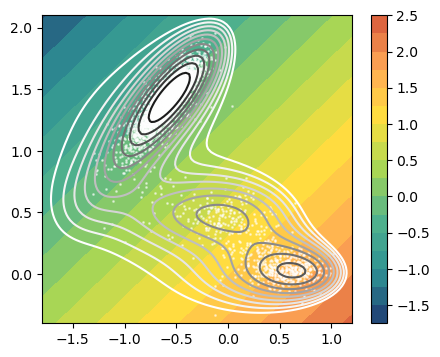

In [5]:
# Inspect linear combination vs potential
fig,axs = plt.subplots( 1, n_components, figsize=(5*n_components,4) )
if n_components == 1:
    axs = [axs]
for i in range(n_components):
    ax = axs[i]
    plot_isolines_2D(muller_brown_potential,levels=np.linspace(0,24,12),mode='contour',ax=ax)
    plot_isolines_2D(tica, component=i, levels=15, ax=ax)
    ax.scatter(X[:,0],X[:,1],s=1, alpha=0.5,c='w')

### DeepTICA CV

To train a DeepTICA CV we need to define the  model and create a trainer object which will optimize the parameters.

#### Define model

In [6]:
from mlcolvar.cvs import DeepTICA

n_components = 1
nn_layers = [2, 15, 15, 5]
options= {'nn': {'activation': 'shifted_softplus'} }

model = DeepTICA(nn_layers, n_cvs=n_components, options=options)
#model.loss_fn.n_eig = n_components

model

DeepTICA(
  (loss_fn): ReduceEigenvaluesLoss()
  (norm_in): Normalization(in_features=2, out_features=2, mode=mean_std)
  (nn): FeedForward(
    (nn): Sequential(
      (0): Linear(in_features=2, out_features=15, bias=True)
      (1): Shifted_Softplus(beta=1, threshold=20)
      (2): Linear(in_features=15, out_features=15, bias=True)
      (3): Shifted_Softplus(beta=1, threshold=20)
      (4): Linear(in_features=15, out_features=5, bias=True)
    )
  )
  (tica): TICA(in_features=5, out_features=1)
)

#### Define Trainer & Fit

In [ ]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from mlcolvar.utils.trainer import MetricsCallback

# define callbacks
metrics = MetricsCallback()
early_stopping = EarlyStopping(monitor="valid_loss", min_delta=1e-5, patience=20)

# define trainer
trainer = lightning.Trainer(callbacks=[metrics, early_stopping],
                     max_epochs=None, logger=None, enable_checkpointing=False)

# fit
trainer.fit( model, datamodule )

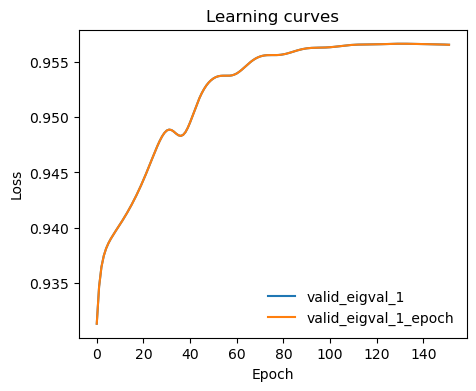

In [8]:
ax = plot_metrics(metrics.metrics,
                  keys=[x for x in  metrics.metrics.keys() if 'valid_eigval' in x],#['train_loss_epoch','valid_loss'],
                  #linestyles=['-.','-'], colors=['fessa1','fessa5'],
                  yscale='linear')

#### Normalize output

We also standardize the outputs by constraing them to be beteween -1 and 1

In [9]:
from mlcolvar.core.transform import Normalization
from mlcolvar.core.transform.utils import Statistics

X = dataset[:]['data']
with torch.no_grad():
    model.postprocessing = None # reset
    s = model(torch.Tensor(X))

norm =  Normalization(n_components, mode='min_max', stats = Statistics(s) )
model.postprocessing = norm
#print(Statistics(s))

#### Plot FES

In [10]:
from mlcolvar.utils.fes import compute_fes

fig,axs = plt.subplots(1,n_components,figsize=(6*n_components,5),dpi=100)
if n_components == 1:
    axs = [axs]

for i in range(n_components):
    # restrict the second CV to the points in which the first is < 0
    fes,grid,bounds,error = compute_fes(s[:,i],
                                        blocks=2,
                                        bandwidth=0.02,scale_by='range',
                                        plot=True, plot_max_fes=100, ax = axs[i])
    axs[i].set_xlabel('Deep-TICA '+str(i+1))

#### Plot CVs isolines

To understand the CVs we can visualize their isolines in the 2D space

In [11]:
fig,axs = plt.subplots( 1, n_components, figsize=(5*n_components,4) )
if n_components == 1:
    axs = [axs]
for i in range(n_components):
    ax = axs[i]

    plot_isolines_2D(muller_brown_potential,levels=np.linspace(0,24,12),mode='contour',ax=ax)
    plot_isolines_2D(model, component=i, levels=np.linspace(-1.,1.,21), ax=ax)
    #ax.scatter(X[:,0],X[:,1],s=1, alpha=0.2,c='w')

An example of dealing with biased simulation is reported in the examples!